# OLMo-core Model Configuration Analysis

This notebook inspects each trained model configuration in detail:
- Total parameters
- Active parameters
- For MoE models: number of shared/routed experts, params per expert
- Clarification on whether active params include the shared expert

In [1]:
import sys
sys.path.insert(0, '/Users/timur/Desktop/Relace/OLMo-core/src')

from olmo_core.nn.transformer import TransformerConfig
from scripts.relace.model_configs import (
    # Dense models
    llama2_271M,
    llama2_135M,
    dense_100K,
    dense_10K,
    # Tiny dense models (Kaplan et al. scaling law series)
    tinydense_500K,
    tinydense_100K,
    tinydense_10K,
    tinydense_1K,
    # MoE models (~1B scale)
    smallmoe_1B,
    smallmoe_1B_A390M,
    smallmoe_300M,
    smallmoe_150M,
    # MoE models (~3B scale)
    smallmoe_3BA300M,
    smallmoe_3BA1B,
    smallmoe_3BA100M,
    smallmoe_3BA30M,
)

# Use GPT-2 vocab size (padded to multiple of 128)
VOCAB_SIZE = 50304  # GPT-2 padded vocab size

/Users/timur/Desktop/Relace/wandb_analysis_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0116 11:55:46.593000 27533 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


## Helper Functions

In [2]:
def format_params(n: int) -> str:
    """Format parameter count with commas and human-readable suffix."""
    if n >= 1e9:
        return f"{n:,} ({n/1e9:.2f}B)"
    elif n >= 1e6:
        return f"{n:,} ({n/1e6:.2f}M)"
    elif n >= 1e3:
        return f"{n:,} ({n/1e3:.2f}K)"
    return f"{n:,}"

def analyze_dense_config(name: str, config: TransformerConfig):
    """Analyze a dense (non-MoE) transformer config."""
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    
    print(f"\n--- Architecture ---")
    print(f"  d_model:        {config.d_model}")
    print(f"  n_layers:       {config.n_layers}")
    print(f"  n_heads:        {config.block.attention.n_heads}")
    if config.block.attention.n_kv_heads:
        print(f"  n_kv_heads:     {config.block.attention.n_kv_heads}")
    print(f"  vocab_size:     {config.vocab_size:,}")
    
    if config.block.feed_forward:
        print(f"  ffn_hidden:     {config.block.feed_forward.hidden_size}")
    
    print(f"\n--- Parameters ---")
    print(f"  Total params:           {format_params(config.num_params)}")
    print(f"  Active params:          {format_params(config.num_active_params)}")
    print(f"  Non-embedding params:   {format_params(config.num_non_embedding_params)}")
    print(f"  Embedding params:       {format_params(config.d_model * config.vocab_size)}")
    
    # For dense models, all params are active
    print(f"\n--- Active Ratio ---")
    ratio = config.num_active_params / config.num_params * 100
    print(f"  Active/Total:           {ratio:.1f}% (always 100% for dense models)")
    
    return {
        'name': name,
        'type': 'dense',
        'total_params': config.num_params,
        'active_params': config.num_active_params,
        'non_embedding_params': config.num_non_embedding_params,
        'd_model': config.d_model,
        'n_layers': config.n_layers,
    }

def analyze_moe_config(name: str, config: TransformerConfig):
    """Analyze an MoE transformer config with detailed expert breakdown."""
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    
    moe = config.block.feed_forward_moe
    
    print(f"\n--- Architecture ---")
    print(f"  d_model:        {config.d_model}")
    print(f"  n_layers:       {config.n_layers}")
    print(f"  n_heads:        {config.block.attention.n_heads}")
    print(f"  vocab_size:     {config.vocab_size:,}")
    
    print(f"\n--- MoE Configuration ---")
    print(f"  num_experts (routed):   {moe.num_experts}")
    print(f"  top_k:                  {moe.router.top_k}")
    print(f"  expert_hidden_size:     {moe.hidden_size}")
    
    has_shared = moe.shared_mlp is not None
    print(f"  has_shared_expert:      {has_shared}")
    if has_shared:
        print(f"  shared_expert_hidden:   {moe.shared_mlp.hidden_size}")
    
    # Calculate params per expert
    params_per_routed_expert = 3 * config.d_model * moe.hidden_size
    print(f"\n--- Params per Expert ---")
    print(f"  Params per routed expert:  {format_params(params_per_routed_expert)}")
    if has_shared:
        params_shared_expert = 3 * config.d_model * moe.shared_mlp.hidden_size
        print(f"  Params in shared expert:   {format_params(params_shared_expert)}")
    
    # Router params
    router_params = config.d_model * moe.num_experts
    print(f"  Router params per layer:   {format_params(router_params)}")
    
    print(f"\n--- Total Parameters ---")
    print(f"  Total params:           {format_params(config.num_params)}")
    print(f"  Active params:          {format_params(config.num_active_params)}")
    print(f"  Non-embedding params:   {format_params(config.num_non_embedding_params)}")
    print(f"  Embedding params:       {format_params(config.d_model * config.vocab_size)}")
    
    # Active ratio
    ratio = config.num_active_params / config.num_params * 100
    print(f"\n--- Active Ratio ---")
    print(f"  Active/Total:           {ratio:.1f}%")
    
    # Breakdown of active params
    print(f"\n--- Active Params Breakdown (per forward pass) ---")
    moe_active_per_layer = moe.num_active_params(config.d_model)
    moe_total_per_layer = moe.num_params(config.d_model)
    
    # What's in active params for MoE:
    # From moe.py: num_active_params = num_params - (all_expert_params) + (top_k_expert_params)
    # This means: router + shared_mlp (if exists) + top_k experts
    
    active_expert_params = 3 * config.d_model * moe.hidden_size * moe.router.top_k
    print(f"  Router params:              {format_params(router_params)} per layer")
    print(f"  Active routed experts:      {moe.router.top_k} x {format_params(params_per_routed_expert)} = {format_params(active_expert_params)} per layer")
    if has_shared:
        print(f"  Shared expert:              {format_params(params_shared_expert)} per layer")
    
    print(f"\n  MoE active params/layer:    {format_params(moe_active_per_layer)}")
    print(f"  MoE total params/layer:     {format_params(moe_total_per_layer)}")
    
    return {
        'name': name,
        'type': 'moe',
        'total_params': config.num_params,
        'active_params': config.num_active_params,
        'non_embedding_params': config.num_non_embedding_params,
        'd_model': config.d_model,
        'n_layers': config.n_layers,
        'num_experts': moe.num_experts,
        'top_k': moe.router.top_k,
        'expert_hidden': moe.hidden_size,
        'shared_hidden': moe.shared_mlp.hidden_size if has_shared else None,
        'active_ratio': ratio,
    }

## Important Note: Active Params and Shared Experts

Looking at the OLMo-core source code (`src/olmo_core/nn/moe/moe.py`), the `num_active_params` method is:

```python
def num_active_params(self, d_model: int) -> int:
    return (
        self.num_params(d_model)
        - (3 * d_model * self.hidden_size * self.num_experts)
        + (3 * d_model * self.hidden_size * self.router.top_k)
    )
```

And `num_params` includes the shared_mlp:
```python
def num_params(self, d_model: int) -> int:
    num_params = 0
    num_params += self.router.num_params(d_model, self.num_experts)
    num_params += 3 * d_model * self.hidden_size * self.num_experts
    if self.shared_mlp is not None:
        num_params += self.shared_mlp.num_params(d_model)  # <-- Shared expert included
    return num_params
```

**Conclusion: YES, the shared expert IS included in active params.**

The calculation subtracts all routed expert params and adds back only `top_k` expert params, but the shared_mlp is never subtracted, so it remains fully active.

## Dense Model Configurations

In [3]:
# Dense models that have been trained
results = []

# dense_10K - Tiny model for scaling law experiments
config_10K = dense_10K(vocab_size=VOCAB_SIZE)
results.append(analyze_dense_config('dense_10K', config_10K))

# dense_100K - Small model for scaling law experiments
config_100K = dense_100K(vocab_size=VOCAB_SIZE)
results.append(analyze_dense_config('dense_100K', config_100K))

# llama2_30M - Using olmo2_30M from TransformerConfig as that's the 30M scale model
config_30M = TransformerConfig.olmo2_30M(vocab_size=VOCAB_SIZE)
results.append(analyze_dense_config('llama2_30M (olmo2_30M)', config_30M))

# Tiny dense models (Kaplan et al. scaling law series)
config_tinydense_1K = tinydense_1K(vocab_size=VOCAB_SIZE)
results.append(analyze_dense_config('tinydense_1K', config_tinydense_1K))

config_tinydense_10K = tinydense_10K(vocab_size=VOCAB_SIZE)
results.append(analyze_dense_config('tinydense_10K', config_tinydense_10K))

config_tinydense_100K = tinydense_100K(vocab_size=VOCAB_SIZE)
results.append(analyze_dense_config('tinydense_100K', config_tinydense_100K))

config_tinydense_500K = tinydense_500K(vocab_size=VOCAB_SIZE)
results.append(analyze_dense_config('tinydense_500K', config_tinydense_500K))


Model: dense_10K

--- Architecture ---
  d_model:        20
  n_layers:       2
  n_heads:        2
  vocab_size:     50,304
  ffn_hidden:     256

--- Parameters ---
  Total params:           2,046,260 (2.05M)
  Active params:          2,046,260 (2.05M)
  Non-embedding params:   1,040,180 (1.04M)
  Embedding params:       1,006,080 (1.01M)

--- Active Ratio ---
  Active/Total:           100.0% (always 100% for dense models)

Model: dense_100K

--- Architecture ---
  d_model:        48
  n_layers:       4
  n_heads:        4
  vocab_size:     50,304
  ffn_hidden:     256

--- Parameters ---
  Total params:           5,014,320 (5.01M)
  Active params:          5,014,320 (5.01M)
  Non-embedding params:   2,599,728 (2.60M)
  Embedding params:       2,414,592 (2.41M)

--- Active Ratio ---
  Active/Total:           100.0% (always 100% for dense models)

Model: llama2_30M (olmo2_30M)

--- Architecture ---
  d_model:        256
  n_layers:       4
  n_heads:        8
  vocab_size:     50,304

In [4]:
# llama2_135M
config_135M = llama2_135M(vocab_size=VOCAB_SIZE)
results.append(analyze_dense_config('llama2_135M', config_135M))


Model: llama2_135M

--- Architecture ---
  d_model:        768
  n_layers:       12
  n_heads:        12
  vocab_size:     50,304
  ffn_hidden:     2048

--- Parameters ---
  Total params:           162,220,800 (162.22M)
  Active params:          162,220,800 (162.22M)
  Non-embedding params:   123,587,328 (123.59M)
  Embedding params:       38,633,472 (38.63M)

--- Active Ratio ---
  Active/Total:           100.0% (always 100% for dense models)


In [5]:
# llama2_271M
config_271M = llama2_271M(vocab_size=VOCAB_SIZE)
results.append(analyze_dense_config('llama2_271M', config_271M))


Model: llama2_271M

--- Architecture ---
  d_model:        1024
  n_layers:       16
  n_heads:        8
  vocab_size:     50,304
  ffn_hidden:     2816

--- Parameters ---
  Total params:           308,577,280 (308.58M)
  Active params:          308,577,280 (308.58M)
  Non-embedding params:   257,065,984 (257.07M)
  Embedding params:       51,511,296 (51.51M)

--- Active Ratio ---
  Active/Total:           100.0% (always 100% for dense models)


In [6]:
# llama2_1B
config_1B = TransformerConfig.llama2_1B(vocab_size=VOCAB_SIZE)
results.append(analyze_dense_config('llama2_1B', config_1B))


Model: llama2_1B

--- Architecture ---
  d_model:        2048
  n_layers:       18
  n_heads:        16
  vocab_size:     50,304
  ffn_hidden:     5632

--- Parameters ---
  Total params:           1,130,964,992 (1.13B)
  Active params:          1,130,964,992 (1.13B)
  Non-embedding params:   1,027,942,400 (1.03B)
  Embedding params:       103,022,592 (103.02M)

--- Active Ratio ---
  Active/Total:           100.0% (always 100% for dense models)


## MoE Model Configurations

In [7]:
# smallmoe_150M - Small MoE with granularity=12
config_smallmoe_150M = smallmoe_150M(vocab_size=VOCAB_SIZE)
results.append(analyze_moe_config('smallmoe_150M', config_smallmoe_150M))


Model: smallmoe_150M

--- Architecture ---
  d_model:        384
  n_layers:       12
  n_heads:        6
  vocab_size:     50,304

--- MoE Configuration ---
  num_experts (routed):   96
  top_k:                  1
  expert_hidden_size:     64
  has_shared_expert:      True
  shared_expert_hidden:   64

--- Params per Expert ---
  Params per routed expert:  73,728 (73.73K)
  Params in shared expert:   73,728 (73.73K)
  Router params per layer:   36,864 (36.86K)

--- Total Parameters ---
  Total params:           131,991,936 (131.99M)
  Active params:          47,942,016 (47.94M)
  Non-embedding params:   112,675,200 (112.68M)
  Embedding params:       19,316,736 (19.32M)

--- Active Ratio ---
  Active/Total:           36.3%

--- Active Params Breakdown (per forward pass) ---
  Router params:              36,864 (36.86K) per layer
  Active routed experts:      1 x 73,728 (73.73K) = 73,728 (73.73K) per layer
  Shared expert:              73,728 (73.73K) per layer

  MoE active params/la

In [8]:
# smallmoe_300M - Medium MoE with granularity=12
config_smallmoe_300M = smallmoe_300M(vocab_size=VOCAB_SIZE)
results.append(analyze_moe_config('smallmoe_300M', config_smallmoe_300M))


Model: smallmoe_300M

--- Architecture ---
  d_model:        576
  n_layers:       12
  n_heads:        9
  vocab_size:     50,304

--- MoE Configuration ---
  num_experts (routed):   96
  top_k:                  1
  expert_hidden_size:     96
  has_shared_expert:      True
  shared_expert_hidden:   96

--- Params per Expert ---
  Params per routed expert:  165,888 (165.89K)
  Params in shared expert:   165,888 (165.89K)
  Router params per layer:   55,296 (55.30K)

--- Total Parameters ---
  Total params:           267,660,864 (267.66M)
  Active params:          78,548,544 (78.55M)
  Non-embedding params:   238,685,760 (238.69M)
  Embedding params:       28,975,104 (28.98M)

--- Active Ratio ---
  Active/Total:           29.3%

--- Active Params Breakdown (per forward pass) ---
  Router params:              55,296 (55.30K) per layer
  Active routed experts:      1 x 165,888 (165.89K) = 165,888 (165.89K) per layer
  Shared expert:              165,888 (165.89K) per layer

  MoE active

In [9]:
# smallmoe_1B - High granularity (256 experts, top_k=1)
config_smallmoe_1B = smallmoe_1B(vocab_size=VOCAB_SIZE)
results.append(analyze_moe_config('smallmoe_1B', config_smallmoe_1B))


Model: smallmoe_1B

--- Architecture ---
  d_model:        768
  n_layers:       12
  n_heads:        12
  vocab_size:     50,304

--- MoE Configuration ---
  num_experts (routed):   256
  top_k:                  1
  expert_hidden_size:     128
  has_shared_expert:      True
  shared_expert_hidden:   128

--- Params per Expert ---
  Params per routed expert:  294,912 (294.91K)
  Params in shared expert:   294,912 (294.91K)
  Router params per layer:   196,608 (196.61K)

--- Total Parameters ---
  Total params:           1,017,484,032 (1.02B)
  Active params:          115,053,312 (115.05M)
  Non-embedding params:   978,850,560 (978.85M)
  Embedding params:       38,633,472 (38.63M)

--- Active Ratio ---
  Active/Total:           11.3%

--- Active Params Breakdown (per forward pass) ---
  Router params:              196,608 (196.61K) per layer
  Active routed experts:      1 x 294,912 (294.91K) = 294,912 (294.91K) per layer
  Shared expert:              294,912 (294.91K) per layer

  Mo

In [10]:
# smallmoe_1B_A390M - OLMo-style (32 experts, top_k=4)
config_smallmoe_1B_A390M = smallmoe_1B_A390M(vocab_size=VOCAB_SIZE)
results.append(analyze_moe_config('smallmoe_1B_A390M', config_smallmoe_1B_A390M))


Model: smallmoe_1B_A390M

--- Architecture ---
  d_model:        1152
  n_layers:       12
  n_heads:        18
  vocab_size:     50,304

--- MoE Configuration ---
  num_experts (routed):   32
  top_k:                  4
  expert_hidden_size:     576
  has_shared_expert:      True
  shared_expert_hidden:   2304

--- Params per Expert ---
  Params per routed expert:  1,990,656 (1.99M)
  Params in shared expert:   7,962,624 (7.96M)
  Router params per layer:   36,864 (36.86K)

--- Total Parameters ---
  Total params:           1,040,063,616 (1.04B)
  Active params:          371,203,200 (371.20M)
  Non-embedding params:   982,113,408 (982.11M)
  Embedding params:       57,950,208 (57.95M)

--- Active Ratio ---
  Active/Total:           35.7%

--- Active Params Breakdown (per forward pass) ---
  Router params:              36,864 (36.86K) per layer
  Active routed experts:      4 x 1,990,656 (1.99M) = 7,962,624 (7.96M) per layer
  Shared expert:              7,962,624 (7.96M) per layer

 

## 3B MoE Model Configurations

In [11]:
# smallmoe_3BA300M - 3B total with ~300M active (~10% ratio, like smallmoe_1B)
config_smallmoe_3BA300M = smallmoe_3BA300M(vocab_size=VOCAB_SIZE)
results.append(analyze_moe_config('smallmoe_3BA300M', config_smallmoe_3BA300M))

# smallmoe_3BA1B - 3B total with ~1.17B active (~37% ratio, OLMo-style)
config_smallmoe_3BA1B = smallmoe_3BA1B(vocab_size=VOCAB_SIZE)
results.append(analyze_moe_config('smallmoe_3BA1B', config_smallmoe_3BA1B))

# smallmoe_3BA100M - 3B total with ~100M active (~3.4% ratio, extreme sparsity)
config_smallmoe_3BA100M = smallmoe_3BA100M(vocab_size=VOCAB_SIZE)
results.append(analyze_moe_config('smallmoe_3BA100M', config_smallmoe_3BA100M))

# smallmoe_3BA30M - 3B total with ~30M active (~1% ratio, ultra-extreme sparsity)
config_smallmoe_3BA30M = smallmoe_3BA30M(vocab_size=VOCAB_SIZE)
results.append(analyze_moe_config('smallmoe_3BA30M', config_smallmoe_3BA30M))


Model: smallmoe_3BA300M

--- Architecture ---
  d_model:        1536
  n_layers:       12
  n_heads:        24
  vocab_size:     50,304

--- MoE Configuration ---
  num_experts (routed):   192
  top_k:                  1
  expert_hidden_size:     256
  has_shared_expert:      True
  shared_expert_hidden:   256

--- Params per Expert ---
  Params per routed expert:  1,179,648 (1.18M)
  Params in shared expert:   1,179,648 (1.18M)
  Router params per layer:   294,912 (294.91K)

--- Total Parameters ---
  Total params:           3,003,459,072 (3.00B)
  Active params:          299,705,856 (299.71M)
  Non-embedding params:   2,926,192,128 (2.93B)
  Embedding params:       77,266,944 (77.27M)

--- Active Ratio ---
  Active/Total:           10.0%

--- Active Params Breakdown (per forward pass) ---
  Router params:              294,912 (294.91K) per layer
  Active routed experts:      1 x 1,179,648 (1.18M) = 1,179,648 (1.18M) per layer
  Shared expert:              1,179,648 (1.18M) per layer

## Summary Table

In [12]:
import pandas as pd

# Create summary dataframe
summary_data = []
for r in results:
    row = {
        'Model': r['name'],
        'Type': r['type'],
        'Total Params': f"{r['total_params']/1e6:.1f}M",
        'Active Params': f"{r['active_params']/1e6:.1f}M",
        'Active %': f"{r['active_params']/r['total_params']*100:.1f}%",
        'd_model': r['d_model'],
        'n_layers': r['n_layers'],
    }
    if r['type'] == 'moe':
        row['Num Experts'] = r['num_experts']
        row['Top-K'] = r['top_k']
        row['Expert Hidden'] = r['expert_hidden']
        row['Shared Hidden'] = r['shared_hidden']
    else:
        row['Num Experts'] = '-'
        row['Top-K'] = '-'
        row['Expert Hidden'] = '-'
        row['Shared Hidden'] = '-'
    summary_data.append(row)

df = pd.DataFrame(summary_data)
print("\n" + "="*100)
print("SUMMARY TABLE")
print("="*100)
display(df)


SUMMARY TABLE


,Model,Type,Total Params,Active Params,Active %,d_model,n_layers,Num Experts,Top-K,Expert Hidden,Shared Hidden
0,dense_10K,dense,2.0M,2.0M,100.0%,20,2,-,-,-,-
1,dense_100K,dense,5.0M,5.0M,100.0%,48,4,-,-,-,-
2,llama2_30M (olmo2_30M),dense,29.2M,29.2M,100.0%,256,4,-,-,-,-
3,tinydense_1K,dense,0.6M,0.6M,100.0%,6,2,-,-,-,-
4,tinydense_10K,dense,2.0M,2.0M,100.0%,20,2,-,-,-,-
5,tinydense_100K,dense,4.1M,4.1M,100.0%,40,5,-,-,-,-
6,tinydense_500K,dense,10.8M,10.8M,100.0%,102,4,-,-,-,-
7,llama2_135M,dense,162.2M,162.2M,100.0%,768,12,-,-,-,-
8,llama2_271M,dense,308.6M,308.6M,100.0%,1024,16,-,-,-,-
9,llama2_1B,dense,1131.0M,1131.0M,100.0%,2048,18,-,-,-,-


## Detailed MoE Analysis

In [13]:
# Detailed MoE comparison
moe_data = []
for r in results:
    if r['type'] == 'moe':
        moe_data.append({
            'Model': r['name'],
            'Total Params': f"{r['total_params']/1e6:.1f}M",
            'Active Params': f"{r['active_params']/1e6:.1f}M", 
            'Active %': f"{r['active_ratio']:.1f}%",
            'Routed Experts': r['num_experts'],
            'Shared Experts': 1 if r['shared_hidden'] else 0,
            'Top-K': r['top_k'],
            'Expert Hidden': r['expert_hidden'],
            'Shared Hidden': r['shared_hidden'] if r['shared_hidden'] else '-',
            'Params/Routed Expert': f"{3 * r['d_model'] * r['expert_hidden'] / 1e3:.1f}K",
            'Params/Shared Expert': f"{3 * r['d_model'] * r['shared_hidden'] / 1e3:.1f}K" if r['shared_hidden'] else '-',
        })

if moe_data:
    moe_df = pd.DataFrame(moe_data)
    print("\n" + "="*100)
    print("MoE DETAILED COMPARISON")
    print("="*100)
    display(moe_df)


MoE DETAILED COMPARISON


,Model,Total Params,Active Params,Active %,Routed Experts,Shared Experts,Top-K,Expert Hidden,Shared Hidden,Params/Routed Expert,Params/Shared Expert
0,smallmoe_150M,132.0M,47.9M,36.3%,96,1,1,64,64,73.7K,73.7K
1,smallmoe_300M,267.7M,78.5M,29.3%,96,1,1,96,96,165.9K,165.9K
2,smallmoe_1B,1017.5M,115.1M,11.3%,256,1,1,128,128,294.9K,294.9K
3,smallmoe_1B_A390M,1040.1M,371.2M,35.7%,32,1,4,576,2304,1990.7K,7962.6K
4,smallmoe_3BA300M,3003.5M,299.7M,10.0%,192,1,1,256,256,1179.6K,1179.6K
5,smallmoe_3BA1B,3126.2M,1163.2M,37.2%,32,1,6,1024,4096,6291.5K,25165.8K
6,smallmoe_3BA100M,3048.7M,103.5M,3.4%,1088,1,1,112,112,225.8K,225.8K
7,smallmoe_3BA30M,3102.6M,29.1M,0.9%,580,1,1,768,192,442.4K,110.6K


## Key Findings

### Does Active Params Include the Shared Expert?

**YES** - The shared expert parameters are fully included in the active parameter count.

From the OLMo-core implementation:
1. `num_params()` includes: router + all routed experts + shared_mlp
2. `num_active_params()` subtracts all routed experts and adds back only `top_k` experts
3. The shared_mlp is never subtracted, so it remains in the active count

### Active Params Formula for MoE:
```
active_params = router_params + (top_k * params_per_expert) + shared_expert_params
```

### Model Summary

**Dense Models:**
- `dense_10K`: ~10K non-embedding params (extremely tiny, for pipeline testing)
- `dense_100K`: ~100K non-embedding params (tiny, for scaling law extrapolation)
- `tinydense_1K`: ~1K non-embedding params (extreme, for pipeline testing)
- `tinydense_10K`: ~10K non-embedding params (Kaplan et al. series)
- `tinydense_100K`: ~100K non-embedding params (Kaplan et al. series)
- `tinydense_500K`: ~500K non-embedding params (Kaplan et al. series)
- `llama2_30M (olmo2_30M)`: ~29M total params
- `llama2_135M`: ~162M total params
- `llama2_271M`: ~309M total params
- `llama2_1B`: ~1.13B total params

**MoE Models (~1B scale, granularity=12, uniform expert sizing):**
- `smallmoe_150M`: ~132M total, ~48M active (~36%)
- `smallmoe_300M`: ~268M total, ~79M active (~29%)
- `smallmoe_1B`: ~1.02B total, ~115M active (~11%)

**MoE Models (~1B scale, OLMo-style, larger shared expert):**
- `smallmoe_1B_A390M`: ~1.04B total, ~371M active (~36%)

**MoE Models (~3B scale):**
- `smallmoe_3BA300M`: ~3.0B total, ~299M active (~10%) - mimics smallmoe_1B style
- `smallmoe_3BA1B`: ~3.1B total, ~1.16B active (~37%) - mimics OLMo smallmoe style
- `smallmoe_3BA100M`: ~3.0B total, ~103M active (~3.4%) - extreme sparsity
- `smallmoe_3BA30M`: ~3.1B total, ~29M active (~0.94%) - ultra-extreme sparsity

### Comparison of the 1B MoE Variants:

| Aspect | smallmoe_1B | smallmoe_1B_A390M |
|--------|-------------|-------------------|
| Total Params | ~1B | ~1B |
| Active Params | ~115M (11%) | ~371M (36%) |
| Routed Experts | 256 | 32 |
| Top-K | 1 | 4 |
| Expert Hidden | 128 | 576 |
| Shared Hidden | 128 | 2304 |
| Granularity | 12 | N/A (OLMo-style) |

### Comparison of the 3B MoE Variants:

| Aspect | smallmoe_3BA300M | smallmoe_3BA1B | smallmoe_3BA100M | smallmoe_3BA30M |
|--------|------------------|----------------|------------------|-----------------|
| Total Params | ~3.0B | ~3.1B | ~3.0B | ~3.1B |
| Active Params | ~299M (10%) | ~1.16B (37%) | ~103M (3.4%) | ~29M (0.94%) |
| d_model | 1536 | 2048 | 672 | 192 |
| Routed Experts | 192 | 32 | 1088 | 580 |
| Top-K | 1 | 6 | 1 | 1 |
| Expert Hidden | 256 | 1024 | 112 | 768 |
| Shared Hidden | 256 | 4096 | 112 | 192 |
| Style | granularity=12 | OLMo-style | extreme sparse | ultra-extreme |

The **smallmoe_1B_A390M** has a much higher active ratio because:
1. Larger shared expert (2304 vs 128 hidden dim)
2. More experts activated per token (top_k=4 vs 1)
3. Larger individual experts (576 vs 128 hidden dim)

The **smallmoe_3BA30M** achieves ultra-low 1% active ratio by:
1. Very small d_model (192) to minimize attention/embedding overhead
2. Large experts (768 hidden) with fewer total (580) to minimize router overhead
3. Inverted granularity pattern (expert_hidden = 4*d_model instead of d_model/6)

/var/folders/rb/2shjjsn54_l40wwc54nxtdvm0000gn/T/ipykernel_27533/2479660420.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models, rotation=45, ha='right')


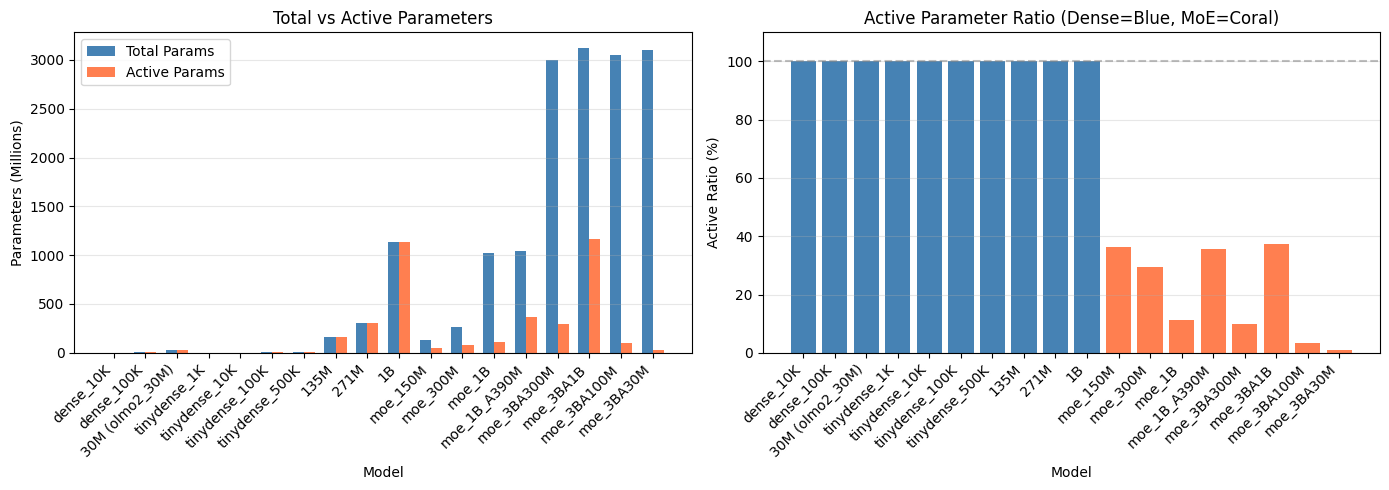

In [14]:
# Visual comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Total vs Active params
ax1 = axes[0]
models = [r['name'].replace('llama2_', '').replace('smallmoe_', 'moe_') for r in results]
total = [r['total_params']/1e6 for r in results]
active = [r['active_params']/1e6 for r in results]

x = range(len(models))
width = 0.35
ax1.bar([i - width/2 for i in x], total, width, label='Total Params', color='steelblue')
ax1.bar([i + width/2 for i in x], active, width, label='Active Params', color='coral')
ax1.set_xlabel('Model')
ax1.set_ylabel('Parameters (Millions)')
ax1.set_title('Total vs Active Parameters')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Active ratio
ax2 = axes[1]
ratios = [r['active_params']/r['total_params']*100 for r in results]
colors = ['steelblue' if r['type'] == 'dense' else 'coral' for r in results]
bars = ax2.bar(models, ratios, color=colors)
ax2.set_xlabel('Model')
ax2.set_ylabel('Active Ratio (%)')
ax2.set_title('Active Parameter Ratio (Dense=Blue, MoE=Coral)')
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='100% (dense)')
ax2.set_ylim(0, 110)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_thurs/param_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Raw Numbers Export

In [15]:
# Export detailed numbers
print("\n" + "="*80)
print("RAW PARAMETER COUNTS")
print("="*80)

for r in results:
    print(f"\n{r['name']}:")
    print(f"  Total params:      {r['total_params']:>15,}")
    print(f"  Active params:     {r['active_params']:>15,}")
    print(f"  Non-embed params:  {r['non_embedding_params']:>15,}")
    print(f"  Active ratio:      {r['active_params']/r['total_params']*100:>14.2f}%")


RAW PARAMETER COUNTS

dense_10K:
  Total params:            2,046,260
  Active params:           2,046,260
  Non-embed params:        1,040,180
  Active ratio:              100.00%

dense_100K:
  Total params:            5,014,320
  Active params:           5,014,320
  Non-embed params:        2,599,728
  Active ratio:              100.00%

llama2_30M (olmo2_30M):
  Total params:           29,167,872
  Active params:          29,167,872
  Non-embed params:       16,290,048
  Active ratio:              100.00%

tinydense_1K:
  Total params:              604,566
  Active params:             604,566
  Non-embed params:          302,742
  Active ratio:              100.00%

tinydense_10K:
  Total params:            2,022,260
  Active params:           2,022,260
  Non-embed params:        1,016,180
  Active ratio:              100.00%

tinydense_100K:
  Total params:            4,124,360
  Active params:           4,124,360
  Non-embed params:        2,112,200
  Active ratio:              

In [16]:
# Calculate true backbone params for tinydense models
print("="*80)
print("TINYDENSE BACKBONE PARAMETER ANALYSIS")
print("="*80)
print("\nThese models are designed for Kaplan et al. scaling law experiments.")
print("The 'backbone params' exclude both input embeddings AND output projection.")
print()

tinydense_configs = [
    ('tinydense_1K', tinydense_1K(vocab_size=VOCAB_SIZE)),
    ('tinydense_10K', tinydense_10K(vocab_size=VOCAB_SIZE)),
    ('tinydense_100K', tinydense_100K(vocab_size=VOCAB_SIZE)),
    ('tinydense_500K', tinydense_500K(vocab_size=VOCAB_SIZE)),
]

backbone_data = []
for name, config in tinydense_configs:
    d = config.d_model
    non_embed = config.num_non_embedding_params
    lm_head_proj = d * config.vocab_size
    lm_head_norm = d
    backbone = non_embed - lm_head_proj - lm_head_norm
    
    # Extract target from name (e.g., "tinydense_500K" -> 500000)
    target_str = name.split('_')[1]
    if target_str.endswith('K'):
        target = int(target_str[:-1]) * 1000
    elif target_str.endswith('M'):
        target = int(target_str[:-1]) * 1000000
    else:
        target = int(target_str)
    
    accuracy = (backbone - target) / target * 100
    
    backbone_data.append({
        'name': name,
        'target': target,
        'backbone': backbone,
        'accuracy': accuracy,
        'd_model': d,
        'n_layers': config.n_layers,
        'non_embed': non_embed,
        'lm_head_proj': lm_head_proj,
    })
    
    print(f"{name}:")
    print(f"  Target:              {target:>10,}")
    print(f"  Backbone params:     {backbone:>10,}")
    print(f"  Accuracy:            {accuracy:>+9.1f}%")
    print(f"  d_model:             {d:>10}")
    print(f"  n_layers:            {config.n_layers:>10}")
    print(f"  ---")
    print(f"  num_non_embedding:   {non_embed:>10,}")
    print(f"  - LM head proj:      {lm_head_proj:>10,}")
    print(f"  - LM head norm:      {lm_head_norm:>10,}")
    print(f"  = Backbone:          {backbone:>10,}")
    print()

# Summary table
print("\n" + "="*80)
print("SUMMARY: Tinydense Backbone Parameters")
print("="*80)
print(f"\n{'Model':<20} {'Target':>12} {'Backbone':>12} {'Accuracy':>10} {'d_model':>8} {'n_layers':>8}")
print("-" * 80)
for b in backbone_data:
    print(f"{b['name']:<20} {b['target']:>12,} {b['backbone']:>12,} {b['accuracy']:>+9.1f}% {b['d_model']:>8} {b['n_layers']:>8}")

TINYDENSE BACKBONE PARAMETER ANALYSIS

These models are designed for Kaplan et al. scaling law experiments.
The 'backbone params' exclude both input embeddings AND output projection.

tinydense_1K:
  Target:                   1,000
  Backbone params:            912
  Accuracy:                 -8.8%
  d_model:                      6
  n_layers:                     2
  ---
  num_non_embedding:      302,742
  - LM head proj:         301,824
  - LM head norm:               6
  = Backbone:                 912

tinydense_10K:
  Target:                  10,000
  Backbone params:         10,080
  Accuracy:                 +0.8%
  d_model:                     20
  n_layers:                     2
  ---
  num_non_embedding:    1,016,180
  - LM head proj:       1,006,080
  - LM head norm:              20
  = Backbone:              10,080

tinydense_100K:
  Target:                 100,000
  Backbone params:        100,000
  Accuracy:                 +0.0%
  d_model:                     40
  n_layer

## Tinydense Models: Backbone Parameter Analysis

### Understanding `num_non_embedding_params` vs True Backbone Params

OLMo-core's `num_non_embedding_params` is defined as:
```python
num_non_embedding_params = total_params - (d_model * vocab_size)
```

This **still includes** the LM head output projection (`d_model × vocab_size`), which scales with vocabulary size.

For scaling law experiments (Kaplan et al. 2020), what matters is the **true backbone params** - parameters that contribute to compute scaling, excluding both:
1. Input embeddings (`d_model × vocab_size`)
2. Output projection (`d_model × vocab_size`) 
3. LM head layer norm (`d_model`)

### Formula:
```
backbone_params = num_non_embedding_params - d_model * vocab_size - d_model
                = num_non_embedding_params - d_model * (vocab_size + 1)
```

This gives us the parameter count that scales with model depth/width, not vocabulary size.

### Conclusion: Tinydense Configs Are Correct

The tinydense model configurations **correctly target** the intended backbone parameter counts:

| Config | Target | Backbone Params | Accuracy |
|--------|--------|-----------------|----------|
| `tinydense_1K` | 1,000 | 912 | -8.8% |
| `tinydense_10K` | 10,000 | 10,080 | +0.8% |
| `tinydense_100K` | 100,000 | 100,000 | exact |
| `tinydense_500K` | 500,000 | 501,024 | +0.2% |

The apparent discrepancy in `num_non_embedding_params` (e.g., tinydense_500K showing ~5.6M) is because OLMo-core's definition still includes the LM head output projection, which scales with `vocab_size`.

**For scaling law experiments**, use the backbone params calculated above, which correctly exclude vocabulary-dependent components.